<a href="https://colab.research.google.com/github/Arajit-Pati/KVASIR-Segmentation/blob/main/Kvasir_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today, we will try to impose U-Net

# First, we will do data analysis

1) Import modules!!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.io as io
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt
import os

The hyperparameters....

In [ ]:
num_epochs = 50
batch_size = 10
learning_rate = 0.001
mean = [0.5571, 0.3217, 0.2358]
std = [0.3181, 0.2213, 0.1871]
saved = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2) Create a data-object

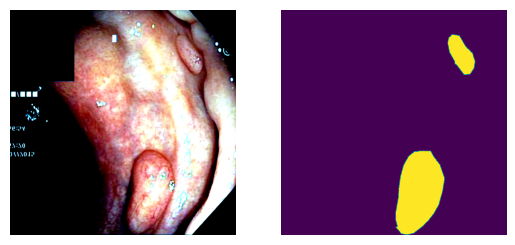

In [ ]:
import random

def visualize(image, mask):
  image = image.to('cpu')
  mask = mask.to('cpu')
  img = image.detach().numpy()
  msk = mask.detach().numpy()

  plt.subplot(1, 2, 1)
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(np.transpose(msk,(1, 2, 0)))
  plt.axis('off')

  plt.show()

def transform(image, mask):
  # Resize
  resize = v2.Resize(size=(512, 512), antialias = True)
  image = resize(image)
  mask = resize(mask)

  # Random horizontal flipping
  if random.random() > 0.5:
      image = v2.functional.horizontal_flip(image)
      mask = v2.functional.horizontal_flip(mask)

  # Random vertical flipping
  if random.random() > 0.5:
      image = v2.functional.vertical_flip(image)
      mask = v2.functional.vertical_flip(mask)

  # normalize the image
  convert = v2.ToDtype(torch.float32, scale = True)
  image = convert(image)
  mask = convert(mask)

  normalize = v2.Normalize(mean = mean, std = std)
  image = normalize(image)

  return image, mask

class DataPicker(Dataset):
  def __init__(self, path, train = False):
    self.head = [os.path.join(path, i) for i in ['images', 'masks']]

    self.samples = []
    files = os.listdir(self.head[0])

    if train == True:
      for file in files[:800]:
        self.samples.append(file)
    else:
      for file in files[800:]:
        self.samples.append(file)

  def __getitem__(self, index):
    image = io.read_image(os.path.join(self.head[0], self.samples[index])).to(device)
    label = io.read_image(os.path.join(self.head[1], self.samples[index]), mode = io.ImageReadMode.GRAY).to(device)
    return transform(image, label)

  def __len__(self):
    return len(self.samples)

path = '/content/drive/MyDrive/Kvasir-SEG'
data = DataPicker(path, train = True)
image, mask = data[1]

# visualization
visualize(image, mask)

__Data analysis__

In [ ]:
# minImg = image.shape
# maxImg = image.shape
# minLab = mask.shape
# maxLab = mask.shape
# for images, masks in data:
#   if minImg < images.shape: minImg = images.shape
#   if maxImg > images.shape: maxImg = images.shape
#   if minLab < masks.shape: minLab = masks.shape
#   if maxLab > masks.shape: maxLab = masks.shape

# print("Min image shape: ", minImg)
# print("Max image shape: ", maxImg)
# print("Min label shape: ", minLab)
# print("Max label shape: ", maxLab)

We would have resized the image into square fits. According to dataset info, minimum size has been 487 by 332 and maximum size has been 1072 by 1920. So, we resized into 432 by 432. Next, we normalized the dataset using mean and standard deviations found as below.

In [ ]:
# mean = [0.0, 0.0, 0.0]
# std = [0.0, 0.0, 0.0]

# for image, label in data:
#   for i in range(3):
#     mean[i] += (torch.sum(image[i]))
#     std[i] += (torch.sum(image[i]*image[i]))

# for i in range(3):
#   mean[i] = mean[i] / (432*432*1000)
#   std[i] = torch.sqrt(std[i] / (432*432*1000) - mean[i]*mean[i])

# print(mean)
# print(std)

__DataLoader__

In [ ]:
train_data = DataLoader(dataset = data, batch_size = batch_size, shuffle = True)

Now, we create model(U-net)

In [ ]:
class DoubleConvolution(nn.Module):
    """
    ### Two $3 \times 3$ Convolution Layers

    Each step in the contraction path and expansive path have two $3 \times 3$
    convolutional layers followed by ReLU activations.

    In the U-Net paper they used $0$ padding,
    but we use $1$ padding so that final feature map is not cropped.
    """

    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: is the number of input channels
        :param out_channels: is the number of output channels
        """
        super().__init__()

        # First $3 \times 3$ convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second $3 \times 3$ convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)


class DownSample(nn.Module):
    """
    ### Down-sample

    Each step in the contracting path down-samples the feature map with
    a $2 \times 2$ max pooling layer.
    """

    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, stride = (2,2))

    def forward(self, x: torch.Tensor):
        return self.pool(x)


class UpSample(nn.Module):
    """
    ### Up-sample

    Each step in the expansive path up-samples the feature map with
    a $2 \times 2$ up-convolution.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=(2,2))

    def forward(self, x: torch.Tensor):
        return self.up(x)


class CropAndConcat(nn.Module):
    """
    ### Crop and Concatenate the feature map

    At every step in the expansive path the corresponding feature map from the contracting path
    concatenated with the current feature map.
    """
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        """
        :param x: current feature map in the expansive path
        :param contracting_x: corresponding feature map from the contracting path
        """

        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        #
        return x


class UNet(nn.Module):
    """
    ## U-Net
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        :param in_channels: number of channels in the input image
        :param out_channels: number of channels in the result feature map
        """
        super().__init__()

        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from $64$.
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                        [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        self.dropout = nn.Dropout(p=0.5)
        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in
                                      [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        # Final $1 \times 1$ convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sig = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        :param x: input image
        """
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two $3 \times 3$ convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two $3 \times 3$ convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)
        x = self.dropout(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two $3 \times 3$ convolutional layers
            x = self.up_conv[i](x)

        # Final $1 \times 1$ convolution layer
        x = self.final_conv(x)
        x = self.sig(x)
        return x

Create a model instance, loss and an optimizer.

In [ ]:
model = UNet(3, 1).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
if saved == False:
  check = {'epochs' : 0,
          'model_st': model.state_dict(),
          'optim' : optimizer.state_dict(),
          'loss' : 0.0,
           'loss_val' : 0.0
          }

torch.Size([10, 3, 512, 512])
torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512])


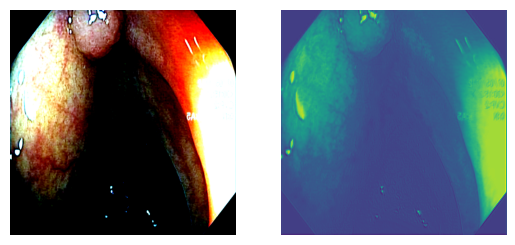

In [ ]:
if saved == True:
  check = torch.load('/content/drive/MyDrive/kvasir.pth')
  model.load_state_dict(check['model_st'])
  optimizer.load_state_dict(check['optim'])


img, msk = next(iter(train_data))
outs = model(img)
print(img.size())
print(msk.size())
print(outs.size())

visualize(img[0], outs[0])

__Train the model__

Evaluation metrics

In [ ]:
def dice_score(preds, target):
  eps = 1e-12
  num = len(preds)
  m1 = preds.detach()
  m2 = target.detach()
  intersect = (m1 * m2).view(num, -1).sum(1)
  m1 = m1.view(num, -1).sum(1)
  m2 = m2.view(num, -1).sum(1)

  for i in range(num):
    if m1[i].item() == 0 and m2[i].item() == 0:
      intersect[i] = 1
    else:
      intersect[i] = (2 * intersect[i]) / (m1[i] + m2[i] + eps)

  return intersect.sum().item() / num

# handful = iter(train_data)
# images, masks = next(handful)

# outputs = model(images)
# #unnormalize
# for i in range(3):
#   outputs[:i] = outputs[:i] * std[i] + mean[i]

# print(dice_score(outputs, masks))

training and saving

In [ ]:
n_total_steps = len(train_data)
running_loss = check['loss']
validation_loss = check['loss_val']
model.train()

for epoch in range(0, num_epochs):
  for i, (images, masks) in enumerate(train_data):
    #forward
    outputs = model(images)
    loss = criterion(outputs, masks)

    #backward
    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    running_loss += (loss.item() * len(masks))

    #validation
    with torch.no_grad():
      toTest = model(images)
      validation_loss += criterion(toTest, masks).item() * len(masks)
      if(i+1) % 10 == 0:
        print(f'epoch {epoch+1} / {num_epochs}, step{i+1} / {n_total_steps}__')
        print(f'Train loss = {validation_loss / ((epoch+1)*len(masks)*(i+1)) :.3f}, || EVAL loss = {running_loss / ((epoch+1)*len(masks)*(i+1)) :.3f}')

  if check['epochs'] == epoch:
    check['epochs'] += 3
    check['model_st'] = model.state_dict()
    check['optim'] = optimizer.state_dict()
    check['loss'] = running_loss
    check['loss_val'] = validation_loss
    saved = True

    torch.save(check, '/content/drive/MyDrive/kvasir.pth')
    break
print('Finished training!!')

OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 141.06 MiB is free. Process 2014 has 14.61 GiB memory in use. Of the allocated memory 13.78 GiB is allocated by PyTorch, and 714.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Test the model

In [ ]:
data_boss = DataPicker(path, train = False)
test_data = DataLoader(dataset = data_boss, batch_size = batch_size, shuffle = True)

dice = []
lessen = []
for images, masks in test_data:
  outputs = model(images)
  lessen.append(criterion(outputs, masks).item())
  dice.append(dice_score(outputs, masks))

plt.figure(1)
plt.plot(dice)
plt.grid('on')

plt.figure(2)
plt.plot(lessen)
plt.grid('on')

#visualize
images,masks = next(iter(test_data))
preds = model(images)

with torch.no_grad():
  model.eval()
  #unnormalize
  for j in range(3):
    images[:j] = images[:j] * std[j] + mean[j]

  plt.figure(3)
  for i in range(4):
    img = images[i].to('cpu').numpy()
    msk = masks[i].to('cpu').numpy()
    pred = preds[i].to('cpu').numpy()

    pred[0] = pred[0] * std[0] + mean[0]

    plt.subplot(3, 4, 1+i)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

    plt.subplot(3, 4, 5+i)
    plt.imshow(np.transpose(msk, (1, 2, 0)))
    plt.axis('off')

    plt.subplot(3, 4, 9+i)
    plt.imshow(np.transpose(pred, (1, 2, 0)))
    plt.axis('off')

  plt.show()